<a href="https://colab.research.google.com/github/hanhluukim/replication-topic-modelling-in-embedding-space/blob/main/notebook_replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Das Projekt aus dem Github klonen und in den Projektsordner**

In [1]:
#wenn die Ordner noch nicht geklont ist, soll dieser Fehler zuerst durchgeführt werden.
!git clone https://github.com/hanhluukim/replication-topic-modelling-in-embedding-space.git

Cloning into 'replication-topic-modelling-in-embedding-space'...
remote: Enumerating objects: 871, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 871 (delta 32), reused 102 (delta 32), pack-reused 769
Receiving objects: 100% (871/871), 370.28 MiB | 11.90 MiB/s, done.
Resolving deltas: 100% (423/423), done.
Checking out files: 100% (90/90), done.


In [2]:
cd /content/replication-topic-modelling-in-embedding-space

/content/replication-topic-modelling-in-embedding-space


#**Die benötige Paketen für das Projekt mittels requirements.txt installieren**



In [3]:
# Falls die Packages noch nicht installiert wurden, 
!pip install -r "/content/replication-topic-modelling-in-embedding-space/requirements.txt"

     |████████████████████████████████| 4.0 MB 4.3 MB/s 
     |████████████████████████████████| 88 kB 6.9 MB/s 
     |████████████████████████████████| 28.8 MB 63.7 MB/s 
     |████████████████████████████████| 636 kB 42.6 MB/s 
     |████████████████████████████████| 79.9 MB 115 kB/s 
     |████████████████████████████████| 880 kB 42.2 MB/s 
     |████████████████████████████████| 6.6 MB 39.3 MB/s 
     |████████████████████████████████| 77 kB 6.3 MB/s 
     |████████████████████████████████| 1.1 MB 35.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=eb0f912e5fc52cbd79fbfe1859f5f7edfc661aec9c12182c63ec03c80b56e691
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=7ae462c6d35e3034dbfc059defeea3ccfe6d647ff0abca34088fc6bdcafe756b
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f

# **Gebrauchte Paketen importieren**

In [4]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import umap.umap_ as umap
import time
import plotly.express as px
from sklearn import cluster
from sklearn import metrics

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# **Vorverarbeitung und BOW-Repräsentationen für Textdaten durchführen**
1. Vocabular erstellen
2. BOW-Repräsentationen für allen Teildatensätzen

In [5]:
from src.prepare_dataset import TextDataLoader

In [6]:
# init TextDataLoader für die Datenquelle 20 News Groups
# Daten abrufen vom Sklearn, tokenisieren und besondere Charaktern entfernen
textsloader = TextDataLoader(source="20newsgroups", train_size=None, test_size=None)
textsloader.load_tokenize_texts("20newsgroups")
# Beispiel von Textdaten
textsloader.show_example_raw_texts(n_docs=2)

loading texts: ...
finished load!
check some sample texts of the dataset
['From', ':', 'lerxst', '@', 'wam', '.', 'umd', '.', 'edu', '(', "where's", 'my', 'thing', ')', 'Subject', ':', 'WHAT', 'car', 'is', 'this', '!', '?', 'Nntp', 'Posting', 'Host', ':', 'rac3', '.', 'wam', '.', 'umd', '.', 'edu', 'Organization', ':', 'University', 'of', 'Maryland', ',', 'College', 'Park', 'Lines', ':', '15', 'I', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'I', 'saw', 'the', 'other', 'day', '.', 'It', 'was', 'a', '2', 'door', 'sports', 'car', ',', 'looked', 'to', 'be', 'from', 'the', 'late', '60s', '/', 'early', '70s', '.', 'It', 'was', 'called', 'a', 'Bricklin', '.', 'The', 'doors', 'were', 'really', 'small', '.', 'In', 'addition', ',', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', '.', 'This', 'is', 'all', 'I', 'know', '.', 'If', 'anyone', 'can', 'tellme', 'a', 'model', 'name', ',', 'engine', 'specs'

In [7]:
# Vorverarbeitung von Daten mit folgenden Schritten:
textsloader.preprocess_texts(length_one_remove=True, punctuation_lower = True, stopwords_filter = True)

start: preprocessing: ...
finised: preprocessing!


In [8]:
# Daten zerlegen für Train, Test und Validation. Erstellen Vocabular aus dem Trainset
min_df=10
textsloader.split_and_create_voca_from_trainset(max_df=0.7, min_df=min_df, stopwords_remove_from_voca=True)

test-document-frequency: 
[[10 12 11 ... 21 22 10]]
vocab-size in df: 1266
start creating vocabulary ...
length of the vocabulary: 1266
sample ten words of the vocabulary: ['pressure', 'set', 'davis', 'baseball', 'paul', 'couple', 'shot', 'return', 'light', 'views']
length word2id list: 1266
length id2word list: 1266
finished: creating vocabulary


# **LDA Model**

In [9]:
from src.evaluierung import topicCoherence
from src.lda import lda
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation, strip_numeric


# Erstellen BOW-Repräsentation für LDA Model
for_lda_model = True 
word2id, id2word, train_set, test_set, val_set = textsloader.create_bow_and_savebow_for_each_set(for_lda_model=for_lda_model)
docs_tr, docs_t, docs_v = textsloader.get_docs_in_words_for_each_set()
#lda model
print(100*"-")

ldamodel = lda(train_set,5,id2word)
lda_topics = ldamodel.show_topics(num_words=10)
topics = []
filters = [lambda x: x.lower(), strip_punctuation, strip_numeric]
for topic in lda_topics:
    #print(topic)
    topics.append(preprocess_string(topic[1], filters))
for topic in topics:
  print(topic)
print(100*"-")
tc = topicCoherence(topics,10,docs_tr,len(docs_tr))
print(tc)

length train-documents-indices : 33578
length of the vocabulary: 1266


start: creating bow representation...
finised creating bow input!

start: creating bow representation...
finised creating bow input!

start: creating bow representation...
finised creating bow input!

start: creating bow representation...
finised creating bow input!

start: creating bow representation...
finised creating bow input!

compact representation for LDA
----------------------------------------------------------------------------------------------------
['version', 'steven', 'health', 'tough', 'hey', 'care', 'reached', 'fact', 'color', 'beginning']
['purdue', 'stuff', 'steven', 'capability', 'color', 'fix', 'wanted', 'care', 'input', 'version']
['version', 'drive', 'care', 'steven', 'color', 'zoo', 'radio', 'heaven', 'stupid', 'differences']
['steven', 'health', 'version', 'event', 'funny', 'heaven', 'basic', 'avoid', 'purdue', 'color']
['tough', 'wanted', 'steven', 'started', 'claimed', 'keywords', 'hp', 

# **Data for ETM**

In [10]:
# Erstellen BOW-Repräsentation für ETM Modell
for_lda_model = False
word2id, id2word, train_set, test_set, val_set = textsloader.create_bow_and_savebow_for_each_set(for_lda_model=for_lda_model)


length train-documents-indices : 33578
length of the vocabulary: 1266


start: creating bow representation...
finised creating bow input!

start: creating bow representation...
finised creating bow input!

start: creating bow representation...
finised creating bow input!

start: creating bow representation...
finised creating bow input!

start: creating bow representation...
finised creating bow input!

id2word befor saving: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 

# **Vocabular und IDs anzeigen als Beispiel**

---





In [11]:
# show for samples: 100 word2id and id2 word
word2id_df_100 = pd.DataFrame()
word2id_df_100['word'] = list(word2id.keys())[:100]
word2id_df_100['id'] = list(word2id.values())[:100]
word2id_df_100

,word,id
0,pressure,0
1,set,1
2,davis,2
3,baseball,3
4,paul,4
...,...,...
95,age,95
96,microsystems,96
97,research,97
98,systems,98


# **Die Größe von Datensätzen kontrollieren**

In [12]:
# Kontrollieren die Größen von verschiedenen Datensätzen
print(f'Size of the vocabulary after prprocessing ist: {len(textsloader.vocabulary)}')
print(f'Size of train set: {len(train_set["tokens"])}')
print(f'Size of val set: {len(val_set["tokens"])}')
print(f'Size of test set: {len(test_set["test"]["tokens"])}')

Size of the vocabulary after prprocessing ist: 1266
Size of train set: 619
Size of val set: 101
Size of test set: 80


# **Dokumenten wiederstellen für Word2Vec Embedding**

---



In [13]:
# re-erstellen von Dokumenten nach der Vorverarbeitungen. Die Dokumenten sind in Wörtern und werden für Word-Embedding Training benutzt
docs_tr, docs_t, docs_v = textsloader.get_docs_in_words_for_each_set()
train_docs_df = pd.DataFrame()
train_docs_df['text-after-preprocessing'] = [' '.join(doc) for doc in docs_tr[:100]]
train_docs_df

,text-after-preprocessing
0,james warning read nntp posting host engineeri...
1,au austin anti question nntp posting host cs o...
2,bill texas university computing services distr...
3,heaven biblical reply university chicago artic...
4,cco caltech kevin nl week california institute...
...,...
95,mi doug distribution world central sale includ...
96,steve reply technology article dale dale write...
97,stanford driver computer science department st...
98,john summary keywords nntp posting host resear...


# **Word-Embedding trainieren mit dem Traindatensatz**

In [14]:
from src.embedding import WordEmbeddingCreator
from pathlib import Path

save_path = Path.joinpath(Path.cwd(), f'prepared_data/min_df_{min_df}')
figures_path = Path.joinpath(Path.cwd(), f'figures/min_df_{min_df}')
Path(figures_path).mkdir(parents=True, exist_ok=True)

wb_creator = WordEmbeddingCreator(model_name="cbow", documents = docs_tr, save_path= save_path)
wb_creator.train(min_count=0, embedding_size= 10)
vocab = list(word2id.keys())
wb_creator.create_and_save_vocab_embedding(vocab, save_path)
wb_creator.cluster_words(save_path, figures_path, n_components=2, text = False)

word-embedding train begins
word-embedding train finished
length of vocabulary from word-embedding model 1266
length of the vocabulary of prepraring-dataset-vocabulary: 1266


100%|██████████| 1266/1266 [00:00<00:00, 41401.81it/s]


Cluster id labels for inputted data
[2 4 9 ... 9 1 6]
Centroids data
[[ 0.58714088  0.52728106 -1.05983313  0.24236726  0.23362403  1.80577983
   0.60254879  0.60409147 -0.96919625  0.14133128]
 [ 0.21385907  0.20075586 -0.38433021  0.09274464  0.07843001  0.67265161
   0.22883592  0.22732528 -0.35920075  0.05847069]
 [ 0.40944863  0.37490399 -0.73557224  0.17180844  0.15519476  1.28447577
   0.43609456  0.42908552 -0.68478379  0.10567106]
 [ 1.41437221  3.39405394  0.93939149 -1.97879255 -2.64822483  5.2866025
  -0.5200575   0.8950612  -2.56293845 -2.95195174]
 [ 0.69152196  0.63065547 -1.21645004  0.28753118  0.25974662  2.13787046
   0.71435512  0.73160176 -1.1378215   0.17792397]
 [ 0.34377837  0.31074557 -0.61088921  0.14541167  0.12450774  1.0731226
   0.36954961  0.36339052 -0.57573718  0.09049771]
 [ 0.27913621  0.25301674 -0.50355441  0.12034975  0.10327871  0.87334312
   0.29907294  0.2963264  -0.46938366  0.07447403]
 [ 0.81910167  0.72291335 -1.49534122  0.36628024  0.32903

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


True

In [15]:
v = list(wb_creator.model.wv.vocab)[0]
vec = list(wb_creator.model.wv.__getitem__(v))
print(f'word-embedding of the word-- {v}: ')
print(f'vector: {vec}')
print(f'dim of vector: {len(vec)}')

word-embedding of the word-- james: 
vector: [0.4450819, 0.38933128, -0.7875455, 0.22560833, 0.23907727, 1.3405247, 0.46859565, 0.39047703, -0.6983147, 0.0925]
dim of vector: 10


# **Word-Embeddings visualieren als Beispiel**


In [16]:
"""
# read word-embedding files
with open(save_path) as f:
  lines = f.readlines()
embedding_data = []
words_data = []
for t in lines:
  w = t.split("\t")[0]
  v = [float(e) for e in t.split("\t")[1].split(" ")]
  words_data.append(w)
  embedding_data.append(v)

# clustering words with KMeans and Words-Vectors
kmeans = cluster.KMeans(n_clusters=10)
kmeans.fit(embedding_data)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
 
print ("Cluster id labels for inputted data")
print (labels)
#print ("Centroids data")
#print (centroids)


# dimension reduction with umap
start = time.time()
reducer = umap.UMAP(random_state=42,n_components=3)
embedding = reducer.fit_transform(embedding_data)
print('Duration: {} seconds'.format(time.time() - start))

# show samples after dim-reduction in dataframe
wb = pd.DataFrame(embedding, columns=['x', 'y', 'z'])
wb['word'] = words_data
wb['cluster'] = ['cluster ' + str(c) for c in labels]

# visualization
fig = px.scatter_3d(wb, 
                    text = wb['word'],
                    x='x', y='y', z='z',
                    color = wb['cluster'],
                    title ="word-embedding-samples")
fig.show()
"""

'\n# read word-embedding files\nwith open(save_path) as f:\n  lines = f.readlines()\nembedding_data = []\nwords_data = []\nfor t in lines:\n  w = t.split("\t")[0]\n  v = [float(e) for e in t.split("\t")[1].split(" ")]\n  words_data.append(w)\n  embedding_data.append(v)\n\n# clustering words with KMeans and Words-Vectors\nkmeans = cluster.KMeans(n_clusters=10)\nkmeans.fit(embedding_data)\n \nlabels = kmeans.labels_\ncentroids = kmeans.cluster_centers_\n \nprint ("Cluster id labels for inputted data")\nprint (labels)\n#print ("Centroids data")\n#print (centroids)\n\n\n# dimension reduction with umap\nstart = time.time()\nreducer = umap.UMAP(random_state=42,n_components=3)\nembedding = reducer.fit_transform(embedding_data)\nprint(\'Duration: {} seconds\'.format(time.time() - start))\n\n# show samples after dim-reduction in dataframe\nwb = pd.DataFrame(embedding, columns=[\'x\', \'y\', \'z\'])\nwb[\'word\'] = words_data\nwb[\'cluster\'] = [\'cluster \' + str(c) for c in labels]\n\n# visual

# **ETM Model**

ETM hat die Architektur eines Variational Autoencoders. 
ETM wird mit den pretrainierten Embedding kombiniert. Die Embeddings für Topics werden als Gewichten eines Teiles des Netzes aktualiert mittels der ELBO Loss

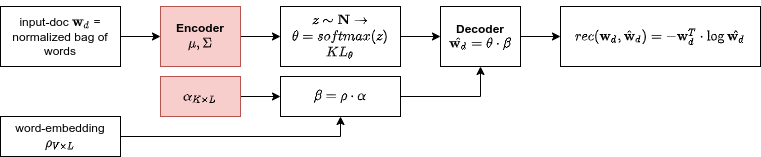

In [17]:
# using DocSet to use easier the modul DataSet from torch
from src.train_etm import DocSet, TrainETM
from src.etm import ETM
import torch

vocab_size = len(list(word2id.keys()))
tr_set = DocSet("train", vocab_size, train_set, normalize_data=True)
print(f'number train-samples: {len(tr_set)}')
print(f'sum of sample vector: {sum(tr_set.__getitem__(0))}')
print(f'length of sample vector: {torch.norm(tr_set.__getitem__(0))}')

number train-samples: 619
sum of sample vector: 1.0
length of sample vector: 0.14657549560070038


**Trainingsparametern vorbereiten**




In [18]:
class TrainArguments:
      def __init__(self, epochs, batch_size, log_interval):
          self.epochs = epochs
          self.batch_size = batch_size
          self.log_interval = log_interval

class OptimizerArguments:
      def __init__(self, optimizer_name, lr, wdecay):
            self.optimizer = optimizer_name
            self.lr = lr
            self.wdecay = wdecay
            
train_args = TrainArguments(epochs=100, batch_size=6, log_interval=None)
optimizer_args = OptimizerArguments(optimizer_name="adam", lr=0.001, wdecay=0.1)
print(train_args.epochs)
print(optimizer_args.optimizer)

from src.embedding import read_prefitted_embedding
embedding_data = read_prefitted_embedding(vocab, save_path)
num_topics = 5
t_hidden_size = 100
rho_size = len(embedding_data[0])
emb_size = len(embedding_data[0])
theta_act = "tanh"

100
adam


**ETM initialisieren**

In [19]:
# define the ETM-model with setting-parameters
etm_model = ETM(
      num_topics, 
      vocab_size, 
      t_hidden_size, rho_size, emb_size, theta_act, 
      embedding_data, 
      enc_drop=0.5)

print(etm_model)

ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): Tanh()
  (topic_embeddings_alphas): Linear(in_features=10, out_features=5, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=1266, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
  )
  (mu_q_theta): Linear(in_features=100, out_features=5, bias=True)
  (logsigma_q_theta): Linear(in_features=100, out_features=5, bias=True)
)


**trainieren**

number of batches: 103
Epoch: 1/100  -  Loss: 7.06875 	 Rec: 7.06593 	 KL: 0.00282
Epoch: 2/100  -  Loss: 6.98901 	 Rec: 6.98851 	 KL: 0.0005
Epoch: 3/100  -  Loss: 6.94449 	 Rec: 6.94417 	 KL: 0.00032
Epoch: 4/100  -  Loss: 6.92798 	 Rec: 6.9278 	 KL: 0.00018
Epoch: 5/100  -  Loss: 6.91552 	 Rec: 6.91544 	 KL: 9e-05
Epoch: 6/100  -  Loss: 6.90756 	 Rec: 6.90751 	 KL: 5e-05
Epoch: 7/100  -  Loss: 6.90359 	 Rec: 6.90356 	 KL: 3e-05
Epoch: 8/100  -  Loss: 6.90112 	 Rec: 6.9011 	 KL: 1e-05
Epoch: 9/100  -  Loss: 6.8996 	 Rec: 6.89959 	 KL: 1e-05
Epoch: 10/100  -  Loss: 6.89908 	 Rec: 6.89907 	 KL: 0.0
Epoch: 11/100  -  Loss: 6.89858 	 Rec: 6.89857 	 KL: 0.0
Epoch: 12/100  -  Loss: 6.89763 	 Rec: 6.89763 	 KL: 0.0
Epoch: 13/100  -  Loss: 6.89754 	 Rec: 6.89754 	 KL: 0.0
Epoch: 14/100  -  Loss: 6.89712 	 Rec: 6.89712 	 KL: 0.0
Epoch: 15/100  -  Loss: 6.89775 	 Rec: 6.89774 	 KL: 0.0
Epoch: 16/100  -  Loss: 6.89767 	 Rec: 6.89767 	 KL: 0.0
Epoch: 17/100  -  Loss: 6.89744 	 Rec: 6.89744 	 KL:

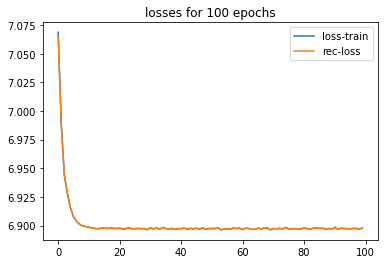

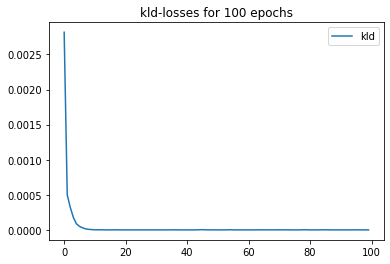

tensor([0.0008, 0.0017, 0.0005,  ..., 0.0004, 0.0005, 0.0006], device='cuda:0')
tensor(1., device='cuda:0')
[('people', 0.0030489342752844095), ('max', 0.002842738525941968), ('make', 0.0028242929838597775), ('time', 0.002808508463203907), ('armenian', 0.002486094832420349), ('good', 0.0024826214648783207), ('years', 0.0024712583981454372), ('made', 0.0023917886428534985), ('point', 0.002356072189286351), ('thing', 0.002269457094371319), ('bit', 0.002261286834254861), ('fact', 0.0022500264458358288), ('find', 0.002242985414341092), ('university', 0.0022178548388183117), ('problem', 0.002212841995060444), ('things', 0.0022048456594347954), ('writes', 0.0021626350935548544), ('back', 0.0021573519334197044), ('government', 0.0021526182536035776), ('state', 0.0021334816701710224)]
[('people', 0.0031000208109617233), ('max', 0.003097032429650426), ('make', 0.002868108218535781), ('time', 0.0028534983284771442), ('armenian', 0.0025178613141179085), ('good', 0.0025176384951919317), ('years', 

In [20]:
#--------------------------training----------------------------------------------------
train_class = TrainETM().train(
    etm_model,
    vocab_size, 
    train_args, optimizer_args, train_set,
    normalize_data = True,
    figures_path = figures_path)
    #num_topics, t_hidden_size, rho_size, emb_size, theta_act,  embedding_data, 0.5)

#-------------------show topics
topics = etm_model.show_topics(id2word, 20)
for tp in topics:
  print(tp)

#----------------
from src.visualization import show_embedding_with_kmeans_umap
show_embedding_with_kmeans_umap(
    id2word, embedding_data, num_topics, etm_model.topic_embeddings_alphas.weight,
    figures_path)

In [23]:
#-------------------show topics
topics = etm_model.show_topics(id2word, 20)
for tp in topics:
  print(tp)


tensor([0.0008, 0.0017, 0.0005,  ..., 0.0004, 0.0005, 0.0006], device='cuda:0')
tensor(1., device='cuda:0')
[('people', 0.0030489342752844095), ('max', 0.002842738525941968), ('make', 0.0028242929838597775), ('time', 0.002808508463203907), ('armenian', 0.002486094832420349), ('good', 0.0024826214648783207), ('years', 0.0024712583981454372), ('made', 0.0023917886428534985), ('point', 0.002356072189286351), ('thing', 0.002269457094371319), ('bit', 0.002261286834254861), ('fact', 0.0022500264458358288), ('find', 0.002242985414341092), ('university', 0.0022178548388183117), ('problem', 0.002212841995060444), ('things', 0.0022048456594347954), ('writes', 0.0021626350935548544), ('back', 0.0021573519334197044), ('government', 0.0021526182536035776), ('state', 0.0021334816701710224)]
[('people', 0.0031000208109617233), ('max', 0.003097032429650426), ('make', 0.002868108218535781), ('time', 0.0028534983284771442), ('armenian', 0.0025178613141179085), ('good', 0.0025176384951919317), ('years', 

In [24]:
topics = [[e[0] for e in tp] for tp in topics]
print(topics)
tc = topicCoherence(topics,num_topics,docs_tr,len(docs_tr))
print(tc)

[['people', 'max', 'make', 'time', 'armenian', 'good', 'years', 'made', 'point', 'thing', 'bit', 'fact', 'find', 'university', 'problem', 'things', 'writes', 'back', 'government', 'state'], ['people', 'max', 'make', 'time', 'armenian', 'good', 'years', 'made', 'point', 'thing', 'bit', 'fact', 'find', 'university', 'problem', 'things', 'writes', 'back', 'government', 'state'], ['people', 'max', 'make', 'time', 'armenian', 'good', 'years', 'made', 'point', 'thing', 'bit', 'fact', 'find', 'university', 'problem', 'things', 'writes', 'back', 'government', 'state'], ['max', 'people', 'make', 'time', 'good', 'armenian', 'years', 'made', 'point', 'thing', 'bit', 'fact', 'find', 'university', 'problem', 'things', 'writes', 'back', 'government', 'state'], ['max', 'people', 'make', 'time', 'good', 'armenian', 'years', 'made', 'point', 'thing', 'bit', 'fact', 'find', 'university', 'problem', 'things', 'writes', 'back', 'government', 'state']]
1.7016579584563827
